In [1]:
import matplotlib.pyplot as plt

from data.LSA_Dataset import LSA_Dataset
from data.transforms import get_frames_reduction_transform, get_roi_selector_transform, get_keypoint_format_transform, get_text_to_tensor_transform

In [2]:
root = '/mnt/data/datasets/cn_sordos_db/data/cuts'
max_frames = 75
keypoints_to_use = [i for i in range(94, 136)]

dataset = LSA_Dataset(
    root,
    load_videos = False,
    frame_transform = get_roi_selector_transform(128,128),
    video_transform = get_frames_reduction_transform(max_frames),
    keypoints_transform = get_frames_reduction_transform(max_frames),
    keypoints_transform_each = get_keypoint_format_transform(keypoints_to_use)
    )
dataset.label_transform = get_text_to_tensor_transform(dataset.vocab.__getitem__("<bos>"), dataset.vocab.__getitem__("<eos>"))

In [3]:
import random

i = random.randint(0, dataset.__len__())
sample = dataset.__getitem__(i)

In [7]:
print(sample[3])
clip = sample[1]
print("[F, C, H, W]", clip.size())
plt.figure(figsize=(12, 12))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    iclip = clip[i, ...].permute(1,2,0)
    plt.imshow(iclip)
    plt.axis("off")

AttributeError: 'list' object has no attribute 'tokens'

In [7]:
keys = list(sample[1])

In [8]:
from torch import stack

print(sample[2])

print(len(keys))
print(keys[0].size())

vid_keys = stack(keys)
print(vid_keys.size())


tensor([   2, 1469, 9092,    6,   16,  967,   28,    6,   27,    8, 5158,    5,
           3])
75
torch.Size([3, 42])
torch.Size([75, 3, 42])


In [13]:
from torch.utils.data import DataLoader
from train import get_collate_fn

dl = DataLoader(dataset, 12, collate_fn=get_collate_fn(dataset.vocab.__getitem__("<pad>")))
for b in dl:
    print(type(b[0][0]))
    print(len(b[0][0]))
    break

<class 'list'>
75


In [6]:
from typing import List
from torch import Tensor, nn

from model.modules.KeypointsEmbedding import KeypointsEmbedding
from model.modules.PositionalEncoding import PositionalEncoding
from model.modules.TokenEmbedding import TokenEmbedding


class KeypointModel(nn.Module):

    def __init__(self,
                src_max_len: int,
                tgt_max_len: int,
                keys_len: int,
                tgt_vocab_size: int,
                kernel_size: int = 5,
                emb_size: int = 64,
                keys_initial_emb_size: int = 128,
                ):
        super(KeypointModel, self).__init__()

        # in_features is the result of flattening the input of (x,y,c).(k1, ..., k42)
        self.keys_emb = KeypointsEmbedding(keys_len=keys_len, kernel_size=kernel_size, emb_size=emb_size, keys_initial_emb_size=keys_initial_emb_size)
        self.src_pe = PositionalEncoding(emb_size=emb_size, max_len=(src_max_len - kernel_size + 1))
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.tgt_pe = PositionalEncoding(emb_size=emb_size, max_len=tgt_max_len)
        self.transformer = nn.Transformer(d_model=emb_size)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        

    def forward(self,
                src: List[Tensor],
                tgt: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.src_pe(self.keys_emb(src))
        tgt_emb = self.tgt_pe(self.tgt_tok_emb(tgt))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.src_pe(self.keys_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.tgt_pe(self.tgt_tok_emb(tgt)), memory, tgt_mask)

In [ ]:
torch.manual_seed(0)

SRC_MAX_LEN = max_frames
TGT_VOCAB_SIZE = len(dataset.vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3


transformer = KeypointModel(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [21]:
print(model(vid_keys, None).size())

torch.Size([71, 1, 32])


In [4]:
import torch

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

print(generate_square_subsequent_mask(5))

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


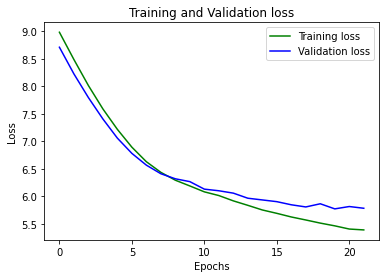

In [8]:
import os
from typing import Optional
from pathlib import Path
import torch

from type_hints import ModelCheckpoint

CHECKPOINT_PATH = Path("checkpoints/")
checkpoint: Optional[ModelCheckpoint] = torch.load(CHECKPOINT_PATH / sorted(os.listdir(CHECKPOINT_PATH))[-1])

loss_train = checkpoint['train_loss_hist']
loss_val = checkpoint['val_loss_hist']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()